Riya & Austin<br/>Section 3

# Question

### What would happen if Olin students kept coming to class during an meningococcal meningitis outbreak?

# Model

### Setting up the environment

In [62]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
import matplotlib.pyplot as plt


# import functions from the modsim.py module
from modsim import *

In [98]:
'''
S: Susceptible
Q: Quarantine
C: Coming to class
R: Recovered
D: Dead XP
'''

init = State(S=360, Q=0, C=2, R=0, D=0)

,values
S,360
Q,0
C,2
R,0
D,0


In [105]:
'''
i: contagion rate
p: proportion quarantined
g: "go home" rate (a.k.a. C->Q rate)
alpha: quarantined recovery rate
beta: quarantined death rate
gamma: coming to class recovery rate
sigma: coming to class death rate
'''

system = System(
    i=0.1 * 5/24 * 86,
    p=0.3,
    g=0.07,
    alpha=0.4,
    beta=0.1,
    gamma=0.001,
    sigma=0.5
)

,values
i,1.791667
p,0.300000
g,0.070000
alpha,0.400000
beta,0.100000
gamma,0.001000
sigma,0.500000


In [106]:
def update_func(state, system, dt=1):
    unpack(state)
    unpack(system)
    
    if S <= 0:
        delta = 0
    else:
        delta = i/S

    infections = min([S * C * delta, S])
    recoveries = min([Q*alpha + C*gamma, 80])
    deaths     = min([Q*beta + C*sigma, 80])
    
    
    dSdt = -infections * dt
    dQdt = (infections * p + C*g - Q*alpha - Q*beta) * dt
    dCdt = (infections * (1-p) - C*gamma - C*sigma - C*g) * dt
    dRdt = (recoveries) * dt
    dDdt = (deaths) * dt
    
    s,q,c,r,d = S,Q,C,R,D
    
    return State(
        S = s + dSdt,
        Q = q + dQdt,
        C = c + dCdt,
        R = r + dRdt,
        D = d + dDdt
    )

In [107]:
def run_simulation(system, init, t_end, dt):
    unpack(system)
    
    results = TimeFrame(columns=init.index)
    results.row[0] = init
    
    for t in linrange(0, t_end, dt):
        results.row[t+dt] = update_func(results.row[t], system, dt)
    
    return results

In [108]:
def plot_results(results):
    plot(results['S'], '-', label='Susceptible')
    plot(results['C'], '--', label='Coming to class')
    plot(results['Q'], ':', label='Quarantined')
    plot(results['R'], '.-', label='Recovered')
    plot(results['D'], '.', label='Dead')
    decorate(xlabel='Time (days)', ylabel='Population')

          S        Q        C         R        D
0       360        0        2         0        0
1   356.417    1.215  3.36633     0.002        1
2   350.385  2.65255   5.6661  0.491366  2.80467
3   340.234  4.76843  9.53699   1.55805  5.90297
4   323.146  8.17794  16.0523   3.47496  11.1483
5   294.386  13.8408  27.0188   6.76219  19.9923
6   245.977  23.3343  45.4771   12.3255  34.8857
7   164.498  39.2945  76.5455   21.7047  59.9577
8   27.3535  66.1487  128.839    37.499   102.16
9         0  50.2991  74.4193   64.0873  173.194
10        0  30.3589  31.9259   84.2814  215.434


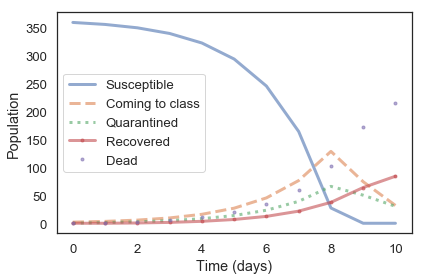

In [110]:
results = run_simulation(system, init, 10, 1)
plot_results(results)
print(results)

# Results

In [ ]:
"""
peeps amount don't matter
"""

# Interpretation